In [282]:
import numpy as np
from neural_net import NeuralNet
%load_ext autoreload
%autoreload 2
import scipy.io
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
filename = "toy_multiclass_1"
nn = NeuralNet.fromMAT(filename, type="train", lam=0)
# print nn.X
# print nn.T

In [284]:
gd = nn.constructGradDescentObject()

In [285]:
lam = 0
print nn.lam
# print "shape(T) = " + str(np.shape(nn.T))
# print "shape(X) = " + str(np.shape(nn.X))
print "shape(W1) = " + str(np.shape(nn.W1))
print "shape(W2) = " + str(np.shape(nn.W2))

0
shape(W1) = (30, 3)
shape(W2) = (3, 31)


In [286]:
nn.forwardProp(nn.X)
print "M = " + str(nn.M)
print "shape(a_hidden) = " + str(np.shape(nn.a_hidden))
print "shape(z) = " + str(np.shape(nn.z))
print "shape(a_outputs) = " + str(np.shape(nn.a_outputs))
print "shape(y) = " + str(np.shape(nn.y))

M = 30
shape(a_hidden) = (30, 300)
shape(z) = (31, 300)
shape(a_outputs) = (3, 300)
shape(y) = (3, 300)


In [287]:
w_list = [np.random.random_sample(np.shape(nn.W1)), np.random.random_sample(np.shape(nn.W2))]
nn.W1 = w_list[0]
nn.W2 = w_list[1]
# nn.forwardProp(nn.X, w_list=w_list)
# nn.computeDeltaOutput(np.arange(0,nn.N))
# print np.shape(nn.deltaOutput)
# print np.shape(nn.W2[:,1:].T)
# nn.backPropFull()
[W1_grad, W2_grad] = nn.evalDerivs(w_list)
print "shape(W1_grad) = " + str(np.shape(W1_grad))
print "shape(W2_grad) = " + str(np.shape(W2_grad))
print "shape(deltaHidden) = " + str(np.shape(nn.deltaHidden))
print "shape(deltaOutput) = " + str(np.shape(nn.deltaOutput))
# t = np.outer(nn.deltaHidden[:,0], nn.X[:,0])
# print np.shape(t)
# s = np.outer(nn.deltaOutput[:,0], nn.z[:,0])
# print np.shape(s)
print W2_grad

shape(W1_grad) = (30, 3)
shape(W2_grad) = (3, 31)
shape(deltaHidden) = (30, 300)
shape(deltaOutput) = (3, 300)
[[ 10.75438699  -6.08114764  -3.22539345 -10.23058821   1.42753858
    4.8175425   -8.7534101   -1.03265923  -8.60408226 -15.28452745
   -3.67986088 -10.54734378  -1.56865287  -5.30032986   1.99422411
   -1.14205194 -11.71895524 -10.55740541  -4.61525655 -14.96938577
   -5.4710492    3.24712797   4.10820521   4.61972444   4.60998692
    1.70824493  -0.23889517   1.96349171  -1.34646091  -3.13045333
   -0.70197468]
 [ 18.24811742  12.80054655  12.5809742   11.84275164   9.34930224
   10.27433799  11.42380671  12.27713852  11.5130053   11.08691774
   12.93289996  10.83704846  12.57992821  12.18596946  12.91830169
   12.83751891  11.92012393  11.08387905  11.53667099  11.56763576
   12.24155574  10.16168492  11.07747285  12.87143075   9.0757905
   11.12514235  11.86353945  12.85609797  10.40523624  12.64996311
   10.01947325]
 [-29.0025044   -6.71939891  -9.35558074  -1.61216343 

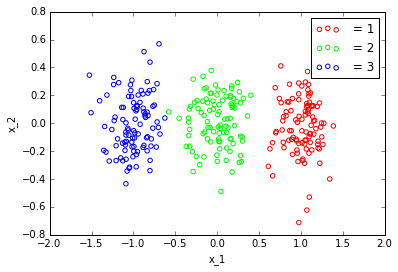

In [288]:
nn.plotData()

function val = -100.579973219
function val after gradient step = -100.597973938
 
--- Minimization Summary --- 
f_min is = -296.012528906
achieved tolerance = -0.000559031146111
numFunctionCalls = 5000
---------------------------- 
 


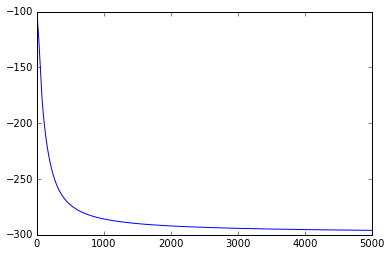

In [289]:
w_initial = [np.random.random_sample(np.shape(nn.W1)), np.random.random_sample(np.shape(nn.W2))]
# w_initial = [nn.W1, nn.W2]
# print w_initial[0]
print "function val = " + str(gd.evalF(w_initial))
gd.stepSize = 1e-5
(w_next, f_next) = gd.gradDescentUpdate(w_initial)
print "function val after gradient step = " + str(f_next)
# print nn.evalCost(nn.lam, w_list=w_initial)
gd.stepSize = 0.001
w_min, f_min, _, _ = gd.computeMin(w_initial, maxFunctionCalls=5000, storeIterValues=True)
gd.plotIterValues()

[array([[ 0.33979944,  0.191683  ,  0.73055588],
       [ 0.62230932,  2.06862363,  0.3915306 ],
       [-0.28645589,  1.60113776,  0.05814238],
       [ 1.12284231, -0.12793668,  1.03132658],
       [ 0.33614161,  0.639067  ,  0.37822784],
       [ 1.01726633, -1.03897815,  0.13953364],
       [ 0.77372748, -1.55866684,  0.64373908],
       [ 0.5270418 ,  0.12987725,  0.25589611],
       [-0.2447582 ,  2.22765056,  0.28059015],
       [ 0.82041361, -0.99353229,  0.13634509],
       [ 0.33803615, -1.33199761,  0.30794038],
       [ 0.10919205,  1.69526296,  0.5985468 ],
       [ 0.97297004, -1.05980171,  0.53816696],
       [ 1.0630147 , -0.65464508,  0.66063002],
       [-0.35133676,  1.70828368,  0.31154084],
       [ 0.06070649,  1.54169984,  0.81568414],
       [ 0.80456837, -0.01045632,  0.69445923],
       [ 0.53693997, -1.64479977,  0.51604305],
       [ 0.66661436,  0.81064604,  0.72052209],
       [ 0.32403099,  0.14090311,  0.91400689],
       [ 0.50631032, -1.18329902,  0.67

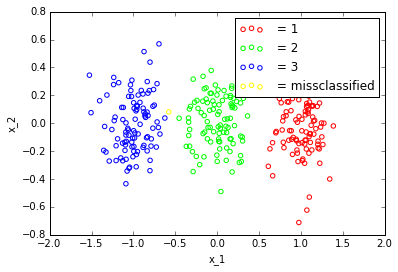

In [290]:
print w_min
nn.forwardProp(nn.X,w_list=w_min)
print nn.y[:,0]
idx = np.where(nn.y[:,0] == np.max(nn.y[:,0]))
print idx
nn.plotNN(w_min)

## Loss Function

We want to compute the loss function. Using the softmax formulation from Bishop the likelihood is $$\prod_n y_n(x,w)^{t_n}$$. Then we get the log likelihood just by taking logs, then we put a negative sign in front in order to convert it to a minimization problem. Then the loss function is $$-\sum_n t_n \log(y_n(x,w)) + \lambda ||w||_2^2 $$

Each $W^{(1)}$ and $W^{(2)}$ (they call them $w^{(1)}$ and $w^{(2)}$) is a matrix of weights:


$$ W^{(1)} = \begin{bmatrix} w_{1,0} & w_{1,1} & ... & ... & w_{1,D}\\
w_{2,0} &w_{2,1} & ... & ... & w_{2,D} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
w_{M,0} &w_{M,1} & ... & ... & w_{M,D}  \end{bmatrix}$$

$$ W^{(2)} = \begin{bmatrix} w_{1,0} & w_{1,1} & ... & ... & w_{1,M}\\
w_{2,0} &w_{2,1} & ... & ... & w_{2,M} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
w_{K,0} &w_{K,1} & ... & ... & w_{K,M}  \end{bmatrix}$$


And we assume $M=N/10$ to start, AKA the amount of hidden units we have in our 1 hidden layer is $M$, and we initialize it to $N/10$, where is $N$ is the number of training examples we have

For our toy dataset, we just have $D$ = 2

The loss function is the NLL and is, given training data and parameters $w$:

$$ l(w) = \sum_{i=1}^N \sum_{k=1}^K \big[ -y_k^{(i)} \log (h_k (x^{(i)}. w)) = (1 - y_k^{(i)}) \log(1-(h_k(x^{(i)},w)) \big] $$

But in order to avoid overfitting, we add regularization terms using the Frobenius norm $$||A||_F$ and use as our cost function:

$$ J(w) = l(w) + \lambda(||w^{(1)}||^2_F + ||w^{(2)}||^2_F $$

### Filling in the holes

The homework description is annoyingly a description of what to do but without enough info to be helpful.

What we also need is the activations:

$$ a_j^{(1)} = \sum_{i=1}^d w_{ji}^{(1)}x_i + w_{j0}^{(1)}$$

And use $g$ to calculate the "feature" for each unit:

$$ z_j = g(a_j) $$


To nicely vectorize our computation of the activations $a$, the first step is to augment our input data with a "1" for each training sample, so that we allow for the $M$ bias weights to be included in the matrix:

$$ x_{aug} = \begin{bmatrix} 1_{N \times 1} &| & x\end{bmatrix} $$

We can now nicely vectorize our computation for the activations:
    
$$ a^{(1)} = W^{(1)} x_{aug} $$

Where we note the dimensionality of each: 
- $x_{aug}$ is a vector of dimension $D+1 \times 1$, where $D$ is the dimensionality of the input data
- $W^{(1)}$ is a matrix of dimension $M \times D+1$, where $M$ is the number of hidden units
- $a^{(1)}$ is a vector of dimension $M \times 1$

Also note that $x_{aug}$ is just for one of the training data samples, $n = 1,...,N$

### Implementing backprop

The notes from class are not super clear, but Bishop 5.3 is.

Here's what we'll do:

- Apply an input vector $x_n$ to the network and forward propagate through the network using 5.48 and 5.49 in order to find the activations of all hidden and output units
- Evaluate the $\delta_k$ for all the output units using 5.54
- Backpropagate the $\delta$'s using 5.56 to obtain $\delta_j$ for each hidden unit in the network
- Use 5.53 to evaluate the required derivatives


5.48 (should be implemented as a matrix multiplication as described above): $$a_j = \sum_i w_{ji}z_i$$

5.49 (is already vectorized as long as $h()$ accepts numpy arrays as input: $$z_j = h(a_j)$$

5.54 (can just be implemented as one subtraction of K-dimensional vectors): $$\delta_k = y_k - t_k$$

5.56 for going from output to hidden layer: $$\delta_j = h'(a_j)\sum_k w_{kj} \delta_k$$

Can be vectorized as:

$$\delta_{prev layer} = h'(a_{prev layer}) \ \  .* \ \ W_{no bias weights}^T \delta_{outputs}  $$

Where .* is element-wise multiply, $\delta_{outputs}$ is a $K$-dimensional vector, $W_{no bias weights}^T$ is $M \times K$

5.53: $$ \frac{\partial E_n}{\partial w_{ji}} = \delta_j z_i $$

Which can be vectorized as on outer product:

$$ \frac{\partial E_n}{\partial W} = z \delta^T$$ 



While implementing as a batch method, we finally sum over all input data samples:


$$ \frac{\partial E}{\partial w_{ji}} = \sum_{n} \frac{\partial E_n}{\partial w_{ji}}$$

In [291]:
print nn.X[0,:]

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [292]:
nn.forwardProp(nn.X[0,:])

IndexError: tuple index out of range

In [ ]:
W2 = np.ones((10,11))
print np.shape(W2)
print np.shape(W2.T)

In [ ]:
1 / (1 + np.exp(-1))

In [ ]:
nn.train()